# Семинар 2

## STL-декомпозиция

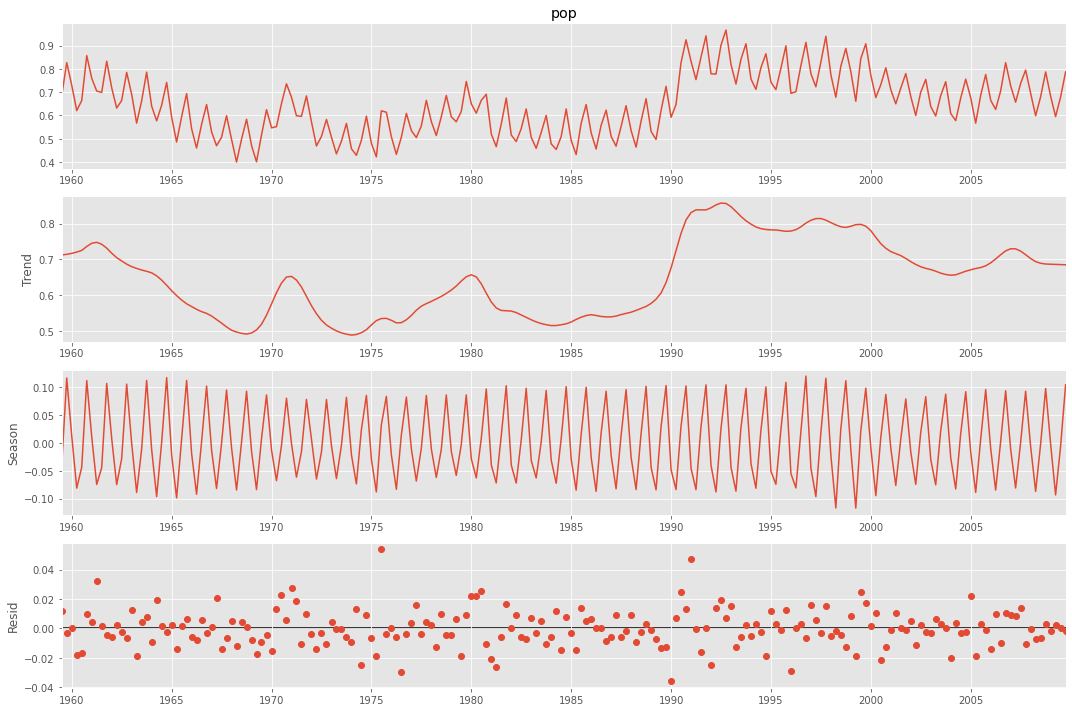

In [32]:
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(data.loc[:,'pop'].diff().dropna(), seasonal=5)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)



In [33]:
res.seasonal

1959-06-30   -0.040279
1959-09-30    0.116039
1959-12-31    0.012008
1960-03-31   -0.081087
1960-06-30   -0.043868
                ...   
2008-09-30    0.097275
2008-12-31   -0.002768
2009-03-31   -0.093207
2009-06-30   -0.006456
2009-09-30    0.103836
Freq: Q-DEC, Name: season, Length: 202, dtype: float64

In [34]:
res.trend

1959-06-30    0.712122
1959-09-30    0.713884
1959-12-31    0.716622
1960-03-31    0.720196
1960-06-30    0.724826
                ...   
2008-09-30    0.686792
2008-12-31    0.686272
2009-03-31    0.685701
2009-06-30    0.685170
2009-09-30    0.684610
Freq: Q-DEC, Name: trend, Length: 202, dtype: float64

## Обработка пропусков

Обработка пропусков во временных рядах связана всё с той же проблемой: данные связаны по времени. Это с одной стороны помогает, а с другой стороны мешает. Разберём некоторые наиболее значимые кейсы.

#### Смотрим на контекст!

Часто само происхождение данных или непосредственно задача диктует правила обработки пропусков. Рассмотрим пример ниже. Вам представлен график недельных цен на некоторый вид химического сырья в некотором регионе мира. В данном случае вполне логично интерпретировать пропуски как "цена не изменилась", поэтому можно заполнить пропуски просто последним доступным значением. С одной стороны это, конечно, снижает дисперсию данных, но при этом он обоснован.

In [35]:
flat = pd.read_csv('data/sem_2/weekly_flat.csv', index_col=0)
flat.index = pd.to_datetime(flat.index)

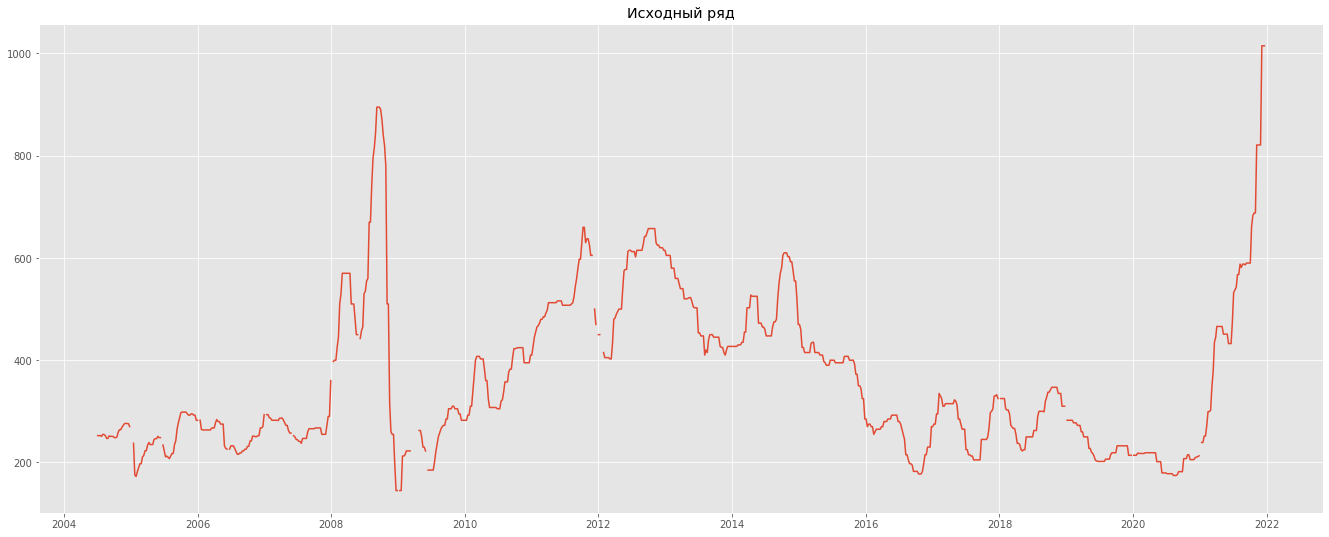

In [36]:

plt.plot(flat)
plt.title('Исходный ряд');

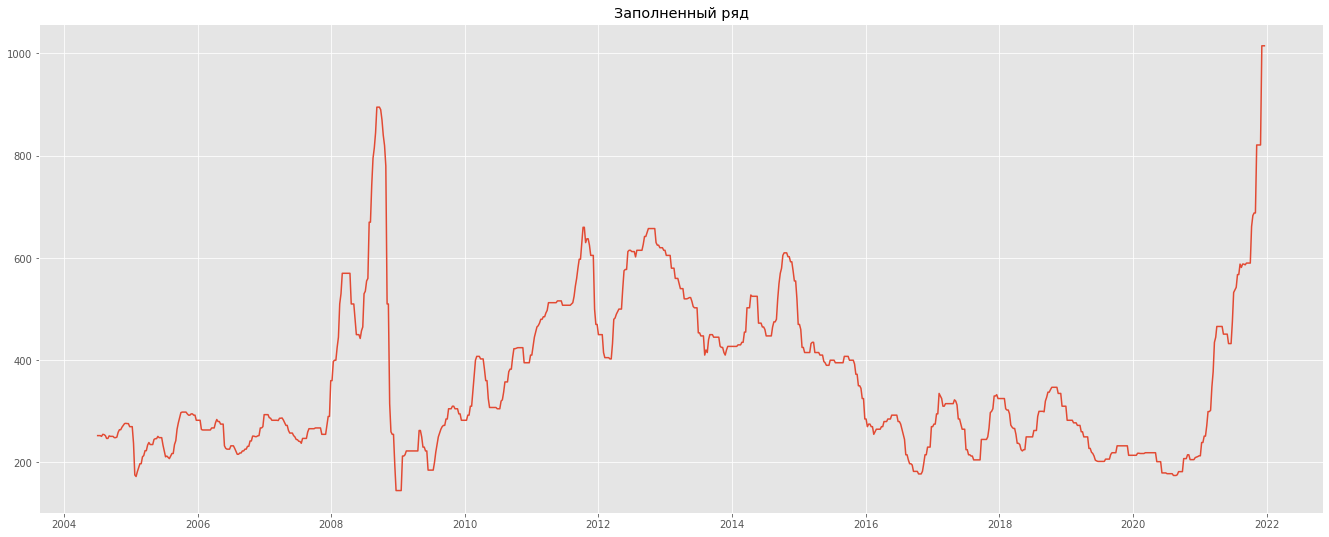

In [37]:

plt.plot(flat.ffill())
plt.title('Заполненный ряд');

#### Смотрим на структуру данных!

Любые паттерны данных и их структура могут помочь в заполнении пропусков. Во-первых, если в данных есть тренд.

In [38]:
mask = np.random.binomial(1, 0.2, size=len(data)) > 0 
gdp_true = data.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

<AxesSubplot:>

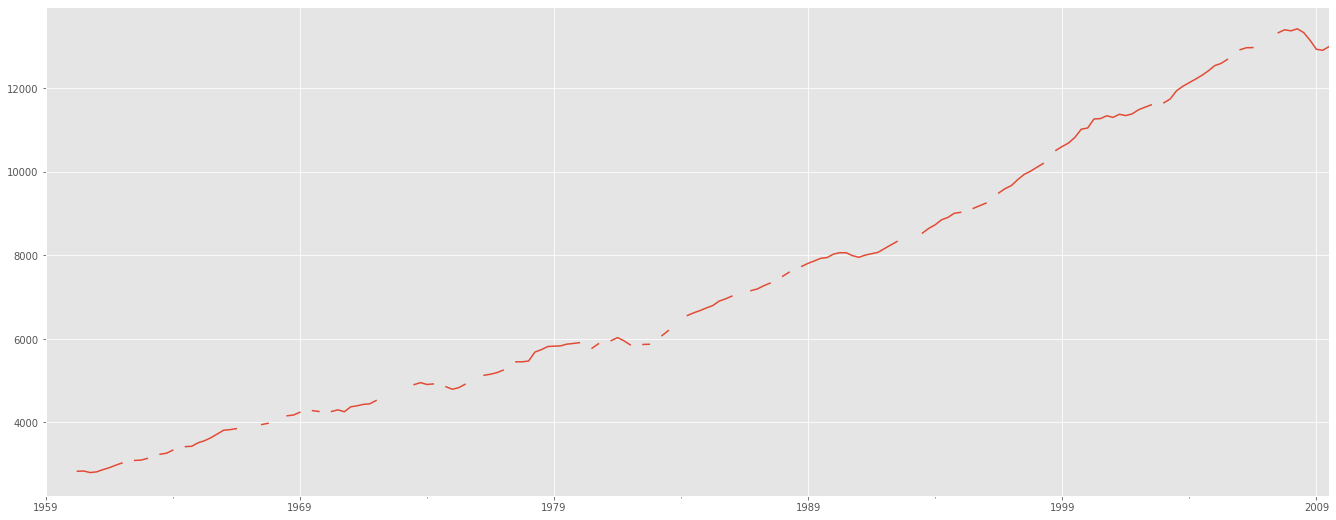

In [39]:
gdp_nan.plot()

<AxesSubplot:>

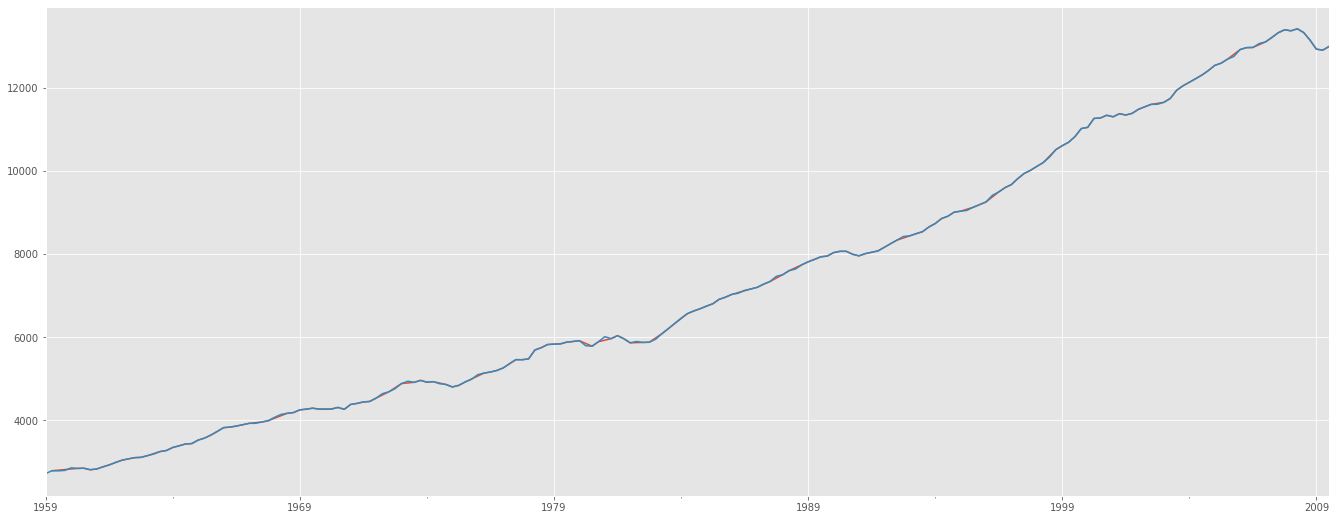

In [40]:
gdp_nan.interpolate(method='linear').plot()
gdp_true.plot()

<AxesSubplot:>

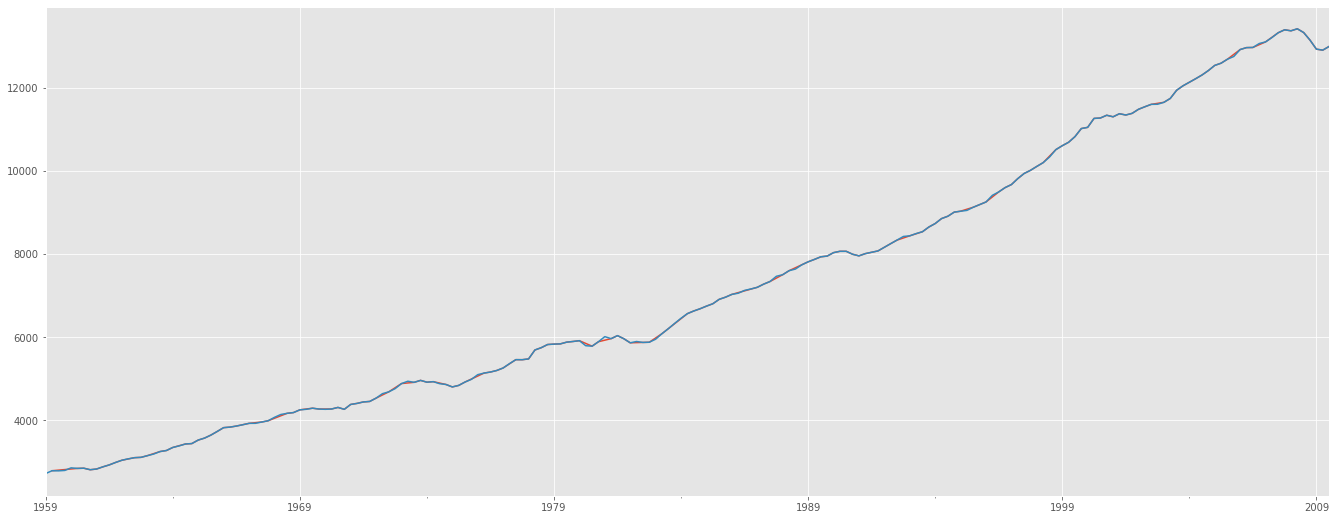

In [41]:
gdp_nan.interpolate(method='time').plot()
gdp_true.plot()

In [42]:
# MAE заполнения
np.abs(gdp_nan.interpolate(method='time') - gdp_true)[mask].mean()

23.04437656702606

## LOWESS

In [43]:
# mask = np.random.binomial(1, 0.1, size=len(data)) > 0 
gdp_true = data.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

gdp_nan = gdp_nan.reset_index(drop=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


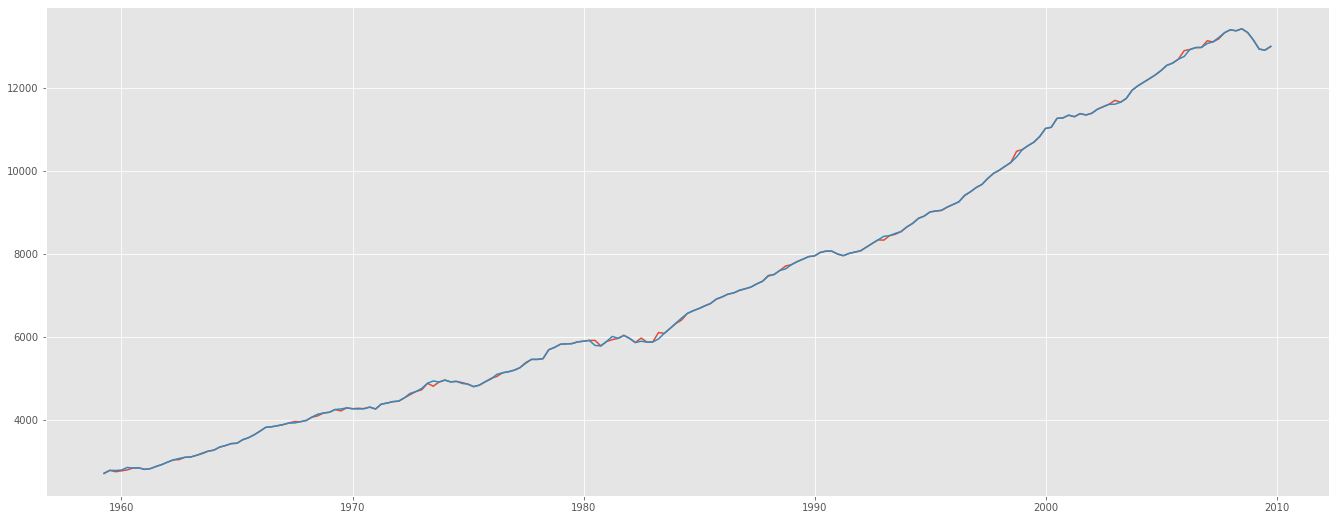

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from moepy import lowess

# Data generation
x = np.array(gdp_nan[~mask].index)
y = gdp_nan[~mask].values

x_pred = np.array(gdp_nan[mask].index)

# Model fitting
lowess_model = lowess.Lowess()
lowess_model.fit(x, y, frac=0.1)

# Model prediction
y_pred = lowess_model.predict(x_pred)
gdp_filled = gdp_nan.copy()
gdp_filled[mask] = y_pred
gdp_filled.index = gdp_true.index

# Plotting
plt.plot(gdp_filled)
plt.plot(gdp_true)
plt.legend(frameon=False)

In [46]:
# MAE заполнения
np.abs(gdp_filled - gdp_true)[mask].mean()

45.72929130824359

В случае, если данные носят сезонный характер, это тоже можно использовать. Например, заполнять последним доступным значением в аналогичном сезоне или усреднять по двум соседним аналогичным сезонам.

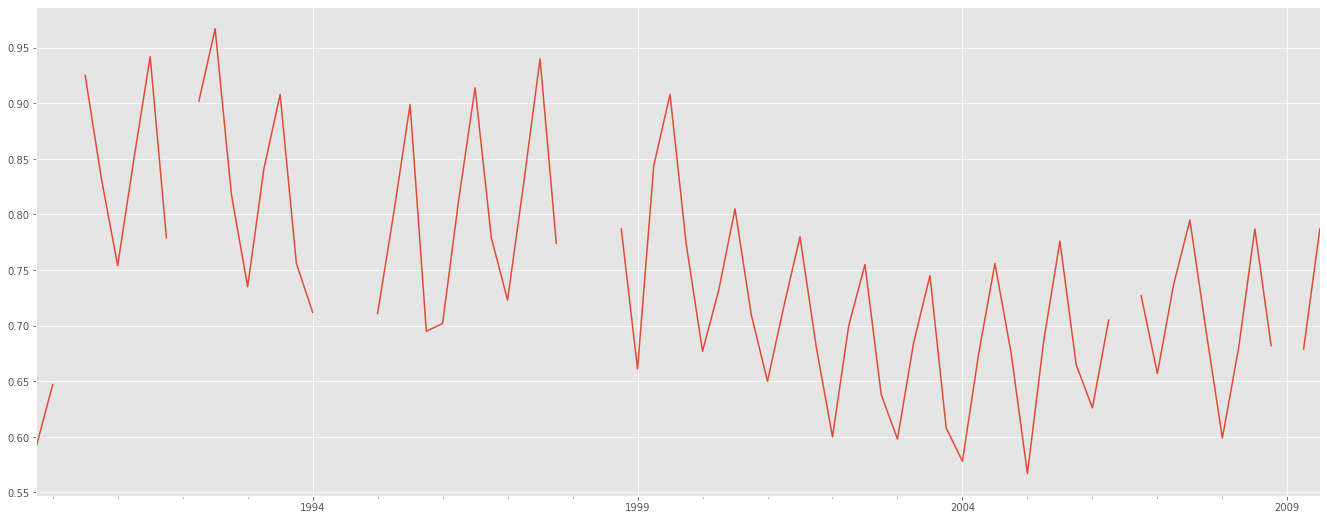

In [47]:
seasonal = data.loc[:,'pop'].diff().dropna().tail(80).copy()

mask = np.random.binomial(1, 0.1, size=len(seasonal)) > 0 

seasonal_nan = seasonal.copy()
seasonal_nan[mask] = np.nan
seasonal_nan.plot()

previous = seasonal.shift(4)
future = seasonal.shift(-4)


# Усредним предудыщий и следующий периоды в аналогичном сезоне
seasonal_nan[seasonal_nan.isna()] = ((previous + future) / 2)[seasonal_nan.isna()]

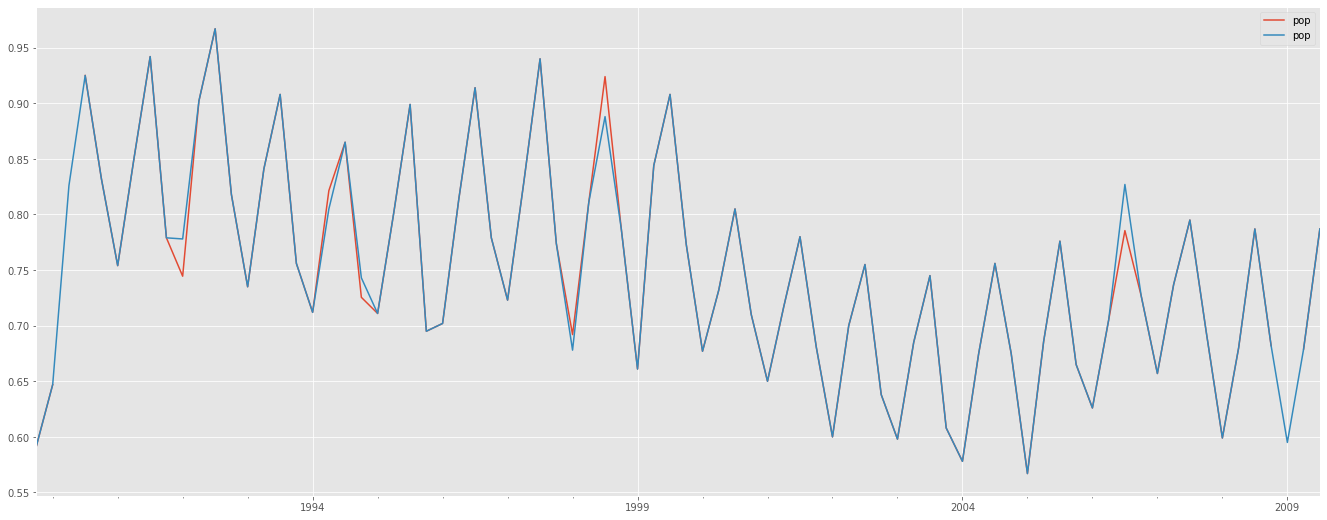

In [48]:
seasonal_nan.plot()
seasonal.plot()
plt.legend()

## Блок о том, почему наш курс не нужен

Первое о чём следует задуматься: а чем, собственно, ряды отличаются от стандартной задачи машинного обучений? Короткий ответ: особо ничем, но есть нюанс. В целом, задачу прогнозирования рядов можно решать как обычную табличную задачу. Сложность обычно в том, что под каждую задачу нужно отдельно возиться с генерацией признаков и порой простая модель временного ряда оказывается выразительнее кучи сгенерированныъ признаков. Сейчас мы попробуем повозиться немного с одной из таких задач. Данные взяты с [kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv). Будем прогнозировать потребление электроэнергии в Испании.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_correlations
from sktime.forecasting.all import temporal_train_test_split
from sklearn.ensemble import RandomForestRegressor
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from catboost import  CatBoostRegressor
import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)



# Загрузим данные по энергетике
data = pd.read_csv('data/sem_2/energy_dataset.csv')

# Преобразуем даты
data.index = pd.to_datetime(data.time.apply(lambda x: x.split('+')[0]))
data = data.drop(columns=['time'])


c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\validation\_dependencies.py:113: UserWarning: No module named 'pmdarima'. 'pmdarima' is a soft dependency and not included in the sktime installation. Please run: `pip install pmdarima` to install the pmdarima package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\validation\_dependencies.py:113: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


In [50]:
# Загрузим данные по погоде
weather = pd.read_csv('data/sem_2/weather_features.csv')

# Преобразуем даты
weather.index = pd.to_datetime(weather.dt_iso.apply(lambda x: x.split('+')[0]))
weather = weather.drop(columns=['dt_iso'])

# Усредним по регионам
weather = weather.groupby('dt_iso').mean()
weather.index.name = 'time'

data = data.merge(weather.loc[:, ['temp']], how='left', left_on='time', right_on='time')
target = data.loc[:,'total load actual'].resample('D').sum()




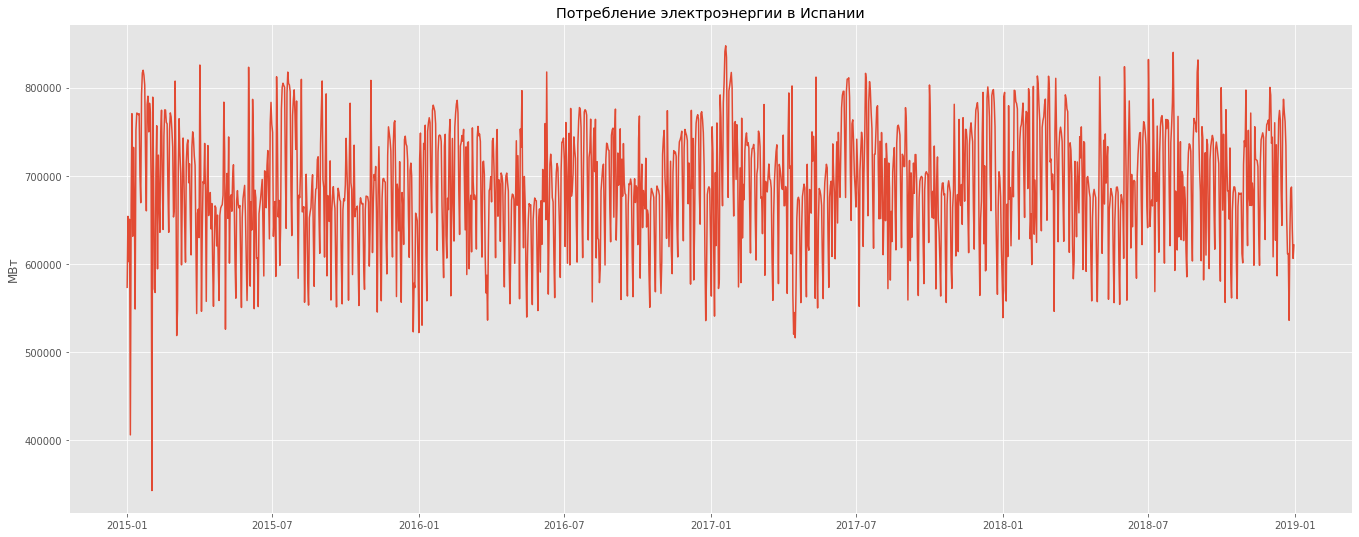

In [51]:
# Найти 
plt.plot(target)
plt.title('Потребление электроэнергии в Испании')
plt.ylabel('МВт');

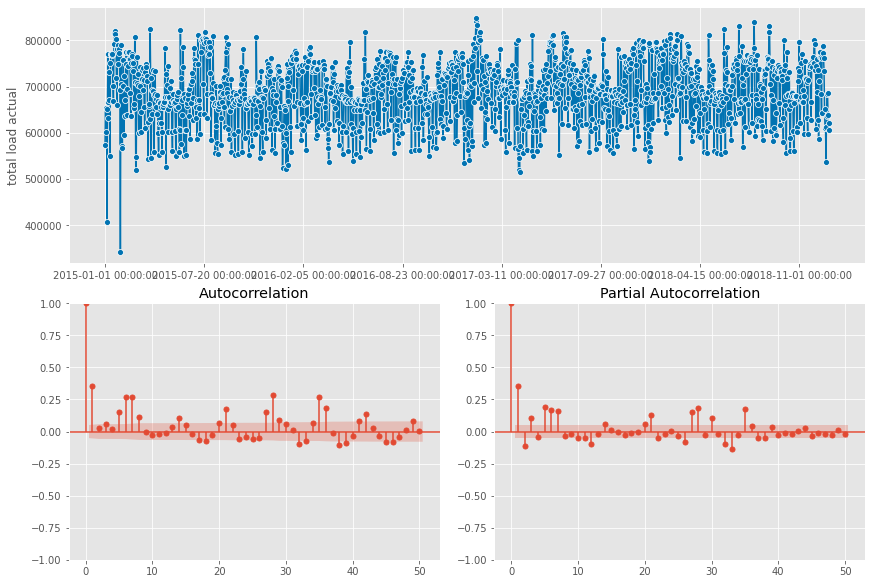

In [52]:
plot_correlations(target, lags=50);

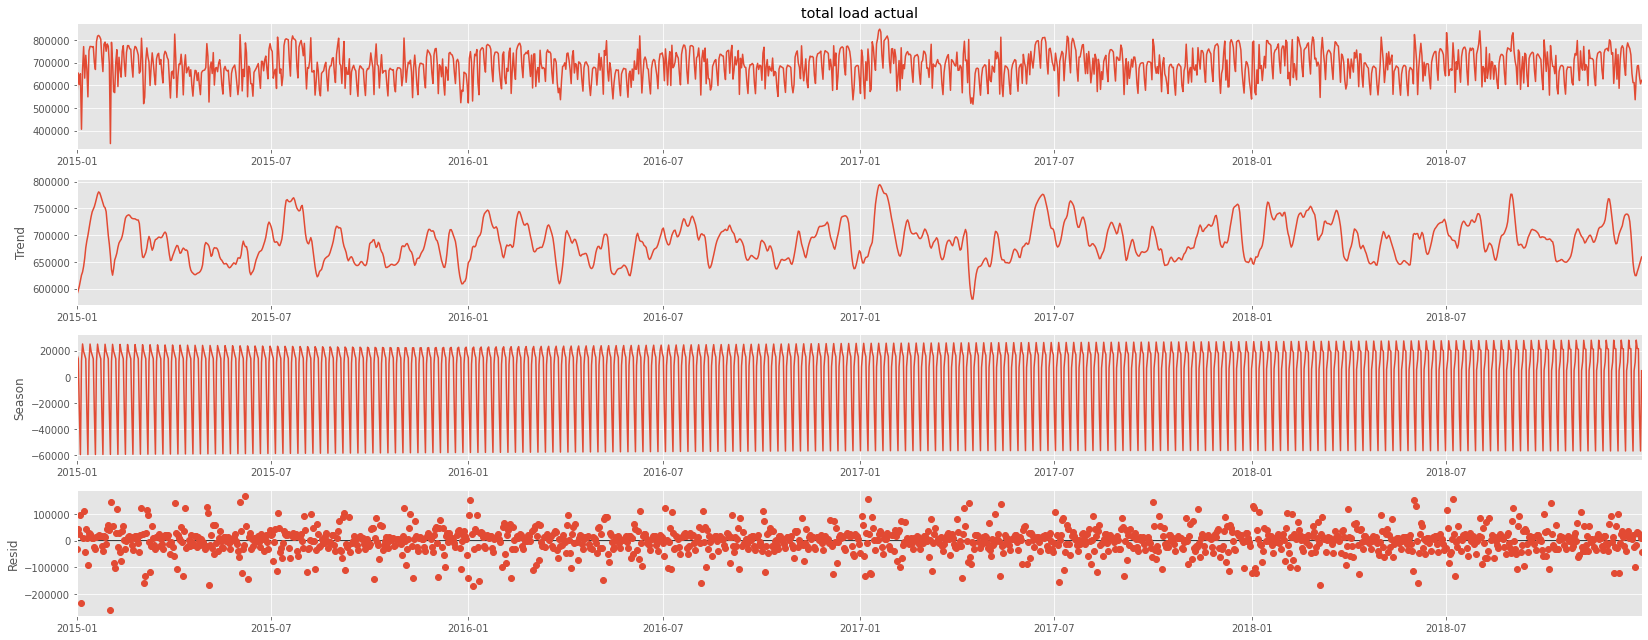

In [53]:
from statsmodels.tsa.seasonal import STL

stl = STL(target, seasonal=365)
res = stl.fit()
res.plot();


In [63]:
import holidays

es_holidays = holidays.Spain()

X = pd.DataFrame()

WINDOW = 10

X['target'] = data.loc[:,'total load actual'].resample('D').sum()
X['y_L1'] = X['target'].shift(1)
X['y_L2'] = X['target'].shift(2)
X['y_L3'] = X['target'].shift(3)
X['y_L4'] = X['target'].shift(4)

X['y_L6'] = X['target'].shift(6)
X['y_L7'] = X['target'].shift(7)
X['y_L31'] = X['target'].shift(31)
X['y_L364'] = X['target'].shift(364)
X['y_L365'] = X['target'].shift(365)
X['y_L366'] = X['target'].shift(366)

X['diff_L1'] = X['target'].diff().shift(1)

# X['rolling_mean'] = X['target'].rolling(WINDOW).mean().shift(1)

# X['month'] = X.index.month
X['day'] = X.index.day
X['weekday'] = X.index.weekday
X['is_weekend'] = X.index.weekday >= 5
X['season'] = X.index.month%12 // 3 + 1
X['temp'] = data.loc[:,'temp'].resample('D').min() * (X.season == 1) + data.loc[:,'temp'].resample('D').max() * (X.season == 3) + data.loc[:,'temp'].resample('D').mean() * ((X.season == 2) | (X.season == 4))
X['temp'] = X['temp'].shift(365)
# X['cos'] = np.cos((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))
X['sin'] = np.sin((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))

X['is_holiday'] = X.index.to_series().apply(lambda x: x in es_holidays)

X = X.dropna()

y = X.target
X = X.drop(columns=['target', "season"])

In [55]:

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

scaler = MinMaxScaler()
cat_features = [
    # 'month',
    'day',
    'weekday',
    'is_weekend',
    'is_holiday',
    # 'season'
    ]
num_features = [col for col in X_train.columns if col not in cat_features]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [56]:


model = CatBoostRegressor(iterations=30, 
                          depth=2, 
                          learning_rate=0.5)

model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)


0.048370470307996856

In [57]:
dict(zip(X.columns, model.feature_importances_))

{'y_L1': 16.403230878799018,
 'y_L2': 1.7277726535744875,
 'y_L3': 1.2783171655063292,
 'y_L4': 4.323496901523081,
 'y_L6': 3.3947781178123977,
 'y_L7': 0.8784127982277044,
 'y_L31': 2.2909407645901645,
 'y_L364': 5.851675575035199,
 'y_L365': 27.255535044325143,
 'y_L366': 2.386789041551432,
 'diff_L1': 2.711721431149765,
 'day': 3.6418281639930923,
 'weekday': 0.0,
 'is_weekend': 22.367382236147055,
 'temp': 0.17132317167491637,
 'sin': 0.8497342552840031,
 'is_holiday': 4.467061800806214}

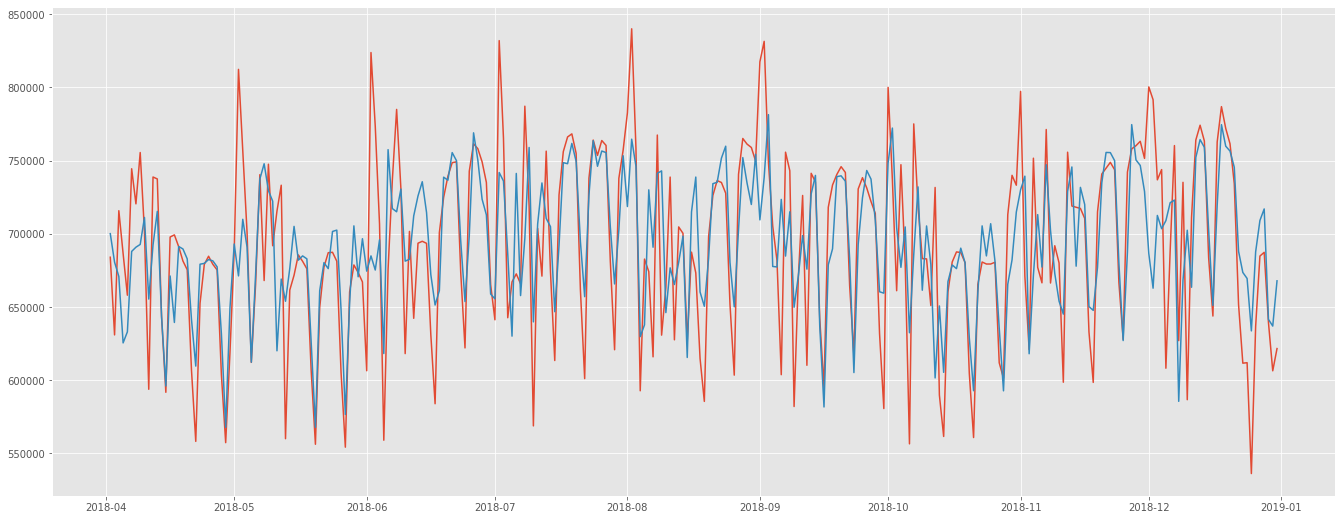

In [58]:
plt.plot(y.tail(len(y_pred)))
plt.plot(y_pred)

## Стратегии многошагового прогнозирования

В предыдущем пункте, казалось бы, всё было хорошо. Мы научились прогнозировать с некоторой относительно неплохой точностью временной ряд. Однако есть одна загвоздка. Мы научились прогнозировать только на один шаг. А хотелось бы, конечно, на много шагов. Именно многошаговое прогнозирование является основной задачей при работе с временными рядами (хотя, конечно, и не всегда). 

Для построения многошаговых прогнозов необходима, как и в одношаговом случае, оценить некоторую модель, а потом с помощью специальной методики (стратегии) применить её для прогнозирования. Мы рассмотрим две основные существующие стратегии: рекурсивная (recursive) и прямая (direct).

## Рекурсивная стратегия

Давайте представим, что нам необходимо спрогнозировать какой-то временной ряд на 5 шагов вперёд. Точку, из которой мы строим прогноз, обычно называют forecast origin, а то, на сколько шагов мы прогнозируем -- горизонт прогнозирования (forecast horizon). Пусть также у нас предполагается самая простая модель:

$$ y_t = \beta_0 + \beta_1 y_{t-1}+ \epsilon_t$$

Как только мы найдём любым доступным способом $\hat{\beta}_0 $ и $\hat{\beta}_1$, то сможем построить прогноз на один шаг вперёд:

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t}$$

На один шаг мы построили. Теперь давайте подумаем про второй. Хотелось бы, конечно, построить следующее уравнение:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 y_{t+1}$$

Однако $y_{t+1}$ мы не знаем. Однако знаем оценку, $\hat{y}_{t+1}$. Ну значит давайте и подставим её, чтобы всё работало. Таким образом прогноз на два шага будет основываться на прогнозе на один шаг:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1}$$

Эту стратегию использую чаще всего. Более того, большая часть статистических моделей, которые мы будем проходить впоследствии, просто технически не могут реализовать какую-то другую. Однако она не лишена недостатков. Один из основных -- накопление ошибки при рекурсивных прогнозах. С каждым шагом ошибка предыдущего шага порождает ещё большу ошибку на последующих. Особенно сильно такой эффект наблюдается, когда модель имеет авторегрессию большего порядка. Значит, что в каждом последующем прогнозе будет учитываться оценка не только предыдущего момента времени, но и оценки всех значений, входящих в уравнение. Например:

$$ \hat{y}_{t+3} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+2} + \hat{\beta}_2 \hat{y}_{t+1} + \hat{\beta}_2 y_{t}$$

Помимо этого существует ещё одна существенная проблема. Давайте снова представим простую модель, но уже с экзогенной переменной $x_t$:

$$ y_t = \beta_0 + \beta_1 y_{t-1} + \gamma_1 x_{t-1} \epsilon_t$$

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t} + + \hat{\gamma}_1 x_{t} $$

При одношаговом прогнозе в целом никаких проблем не возникает. Однако на втором шаге уже проблемы: 

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1} + \hat{\gamma}_1 x_{t+1} $$

$x_{t+1}$ нам взять неоткуда. Следовательно, у нас два варианта. Либо прогнозировать отдельно ряд $x_t$, что добавит ещё больше шума в модель, либо не использовать этот регрессор вообще и полагаться только на фичи, которые либо основаны на $y_t$ (тоже добавит шума), либо могут быть сгенерированы независимо (например, календарные фичи). На самом деле часто бывают задачи, в которых экзогенных переменных нет вовсе и такая проблема не стоит, но всё же это достаточно редкий случай. 

Наши данные из-за большого количества экзогенных и производных переменных не подойдут под рекурсивную стратегию, поэтому приведём здесь пример на более игрушечных данных.

In [59]:
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import make_reduction

# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sklearn.linear_model import LinearRegression

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=40)
fh = ForecastingHorizon(y_test.index, is_relative=False)

0.15450840467307853

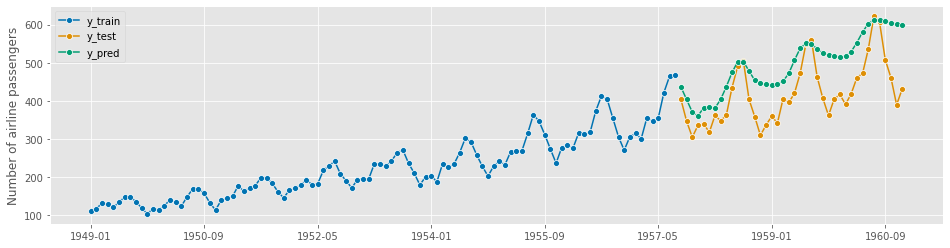

In [60]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=10, strategy="recursive")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## Прямая стратегия

Внимательный слушатель резонно задастся вопросом: А зачем, собственно, предсказывать все горизонты одной моделью. И правда, да ничего не мешает. Пусть нам нужно прогнозировать на h шагов. Тогда оценим h моделей вида:

$$ \hat{y}_{t+1} = \hat{\beta}_0^1 + \hat{\beta}_1^1 y_{t}$$

$$ \hat{y}_{t+2} = \hat{\beta}_0^2 + \hat{\beta}_1^2 y_{t}$$

$$ \hat{y}_{t+3} = \hat{\beta}_0^3 + \hat{\beta}_1^3 y_{t}$$

$$ \cdots $$

$$ \hat{y}_{t+k} = \hat{\beta}_0^k + \hat{\beta}_1^k y_{t}$$

Недостатки такого подхода:
* Вместо одной модели нужно оценивать h. Это очень сильно увеличивает вычислительные затраты, особенно при кросс-валидации.
* Растёт общий разброс модели, так как оцениваем в h раз больше параметров.

Преимущества такого подхода:
* Очевидно, меньше смещение. Ошибки предыдущих горизонтов не влияют на проноз по текущему.
* Более явная модель для многошагового прогноза. Можно, например, подобрать одни переменные, важные для прогноза на длинный период и друге для короткого. 
* Обычно высокий разброс не так критичен как смещение рекурсивной стратегии и в моей практике я стараюсь использовать прямую стратегию.
* Никаких проблем с экзогенными и производными переменными.
* Часто очень неплохо работает вкупе с обычной линейной регрессией и при грамотно сгенерированных фичах

0.04061570008131543

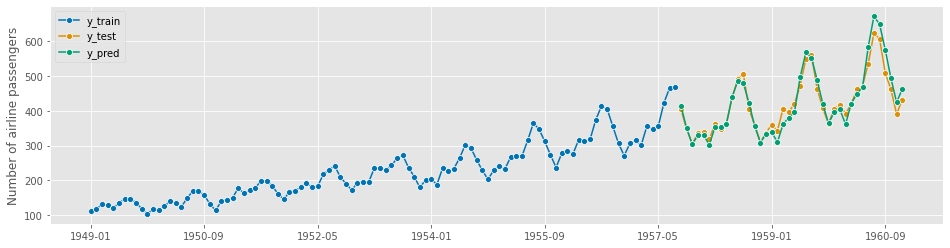

In [61]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=10, strategy="direct")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:611: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:83: Fut

0.07547053289570872

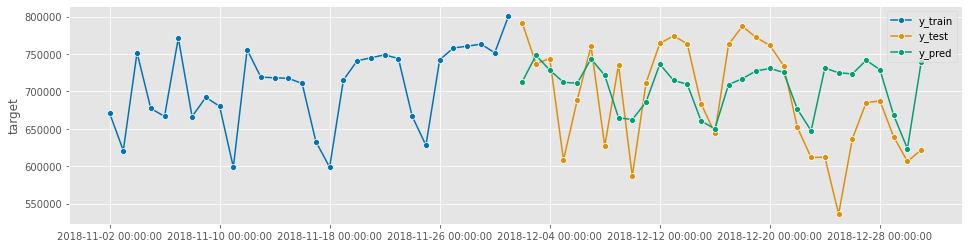

In [64]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=30)

scaler = MinMaxScaler()
cat_features = [
    # 'month',
    'day',
    'weekday',
    'is_weekend',
    'is_holiday',
    # 'season'
    ]
num_features = [col for col in X_train.columns if col not in cat_features]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

fh = ForecastingHorizon(y_test.index, is_relative=False)

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=5, strategy="direct")

forecaster.fit(y_train, X=X_train, fh=fh);
y_pred = forecaster.predict()
plot_series(y_train.tail(30), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## Бенчмарки

In [65]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# step 1: splitting historical data
# y = load_airline()
# y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=False)
# if function interface is used, just use the function directly in step 4

# step 4: computing the forecast performance
mape(y_test, y_pred)

# step 5: testing forecast performance against baseline
# under development

c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:611: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
c:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:83: Fut

0.11524182452059722